In [4]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import math
import torch
from torch.utils.data.dataset import Dataset
import segmentation_models_pytorch as smp
import rasterio
from torch.utils.data import DataLoader

In [5]:

IMGS_DIR = "C:/Users/Deepali Thakur/OneDrive - University of Suffolk/Desktop/DEEPLEARNING/images"
MASKS_DIR = "C:/Users/Deepali Thakur/OneDrive - University of Suffolk/Desktop/DEEPLEARNING/masks"
IMG_CHIPS_DIR = "C:/Users/Deepali Thakur/Landcover/chips/img"
MSK_CHIPS_DIR = "C:/Users/Deepali Thakur/Landcover/chips/msk"
TARGET_SIZE = 512


In [6]:
os.chdir("C:/Users/Deepali Thakur/Landcover/data")
train = pd.read_csv('C:/Users/Deepali Thakur/Landcover/data.csv')

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
class MultiClassSegDataset(Dataset):
    
    def __init__(self,mode,df, classes=None, transform=None,):
        self.df = df
        self.mode = mode
        self.classes = classes
        self.transform = transform
    
    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx, 2]
        mask_name = self.df.iloc[idx, 3]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
        image = image.astype('uint8')
        #mask = mask[:,:,0]
        #mask = np.expand_dims(mask, axis=2)
        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)   
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        else: 
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)
            image = image.float()/255
            mask = mask.long().unsqueeze(0)
        return image, mask  
        
    def __len__(self):
        return len(self.df)


In [8]:
train_set = MultiClassSegDataset(mode = "C:/Users/Deepali Thakur/Landcover/data.csv",
                                df=train)
train_dloader = DataLoader(train_set,batch_size = 3,num_workers =0)

class_dist = {"background":0, "building":0,
                     "woodland":0, "water":0, "road":0}
label_mapping = {0: "background", 1: "building",
                2: "woodland", 3: "water", 4: "road"}

for img,mask in train_dloader:
    for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

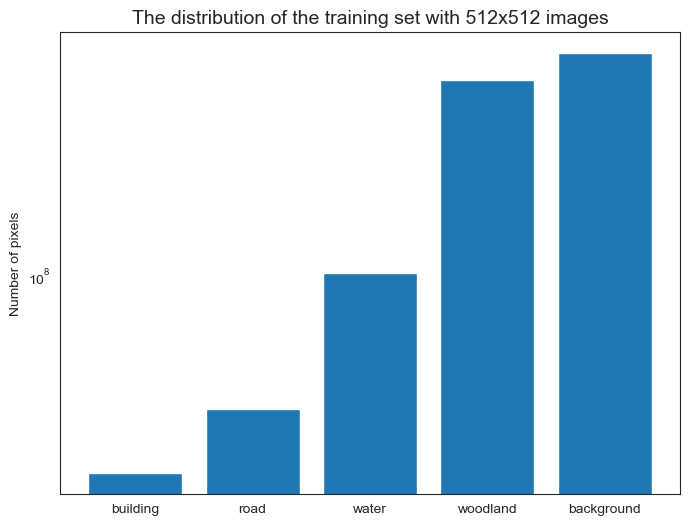

In [9]:
temp_list = sorted([(l,s) for (l,s) in class_dist.items()], key= lambda x: x[1])
labels = [x[0] for x in temp_list]
support = [x[1] for x in temp_list]

sns.set_style("white")
fig, ax = plt.subplots(figsize = (8,6))
ax.bar(labels, support)
ax.set_yscale("log")
ax.set_title("The distribution of the training set with 512x512 images",
            fontsize = 14)
ax.set_ylabel("Number of pixels")
plt.savefig("Barplt.png")
plt.show()

In [ ]:
#os.chdir("C:/users/Deepali Thakur/Landcover")
img_paths = glob.glob(os.path.join(IMGS_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))
img_paths.sort()
mask_paths.sort()

In [ ]:
os.makedirs(IMG_CHIPS_DIR)
os.makedirs(MSK_CHIPS_DIR)
for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                out_img_path = os.path.join(IMG_CHIPS_DIR, "{}_{}.PNG".format(img_filename, k))
                cv2.imwrite(out_img_path, img_tile)

                out_mask_path = os.path.join(MSK_CHIPS_DIR, "{}_{}.PNG".format(mask_filename, k))
                cv2.imwrite(out_mask_path, mask_tile)

            k += 1

    print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))

In [ ]:
temp_img = cv2.imread("C:/Users/Deepali Thakur/Landcover/chips/img/M-33-7-A-d-2-3_27.PNG")
temp_img.shape
plt.imshow(temp_img[:,:,1])

In [ ]:
temp_mask = cv2.imread("C:/Users/Deepali Thakur/Landcover/chips/msk/M-33-7-A-d-2-3_27.PNG")
temp_img.shape
plt.imshow(temp_mask[:,:,1])

In [22]:
train_img_dir = "C:/Users/Deepali Thakur/Landcover/data/train_images/train/"
train_mask_dir = "C:/Users/Deepali Thakur/Landcover/data/train_masks/train/"
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [23]:
num_images = len(os.listdir(train_img_dir))

In [24]:
import random
img_num = random.randint(0, num_images-1)

In [25]:
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 2)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
img_for_plot.shape

(512, 512, 3)

In [26]:
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 1)

mask_for_plot.shape

(512, 512, 3)

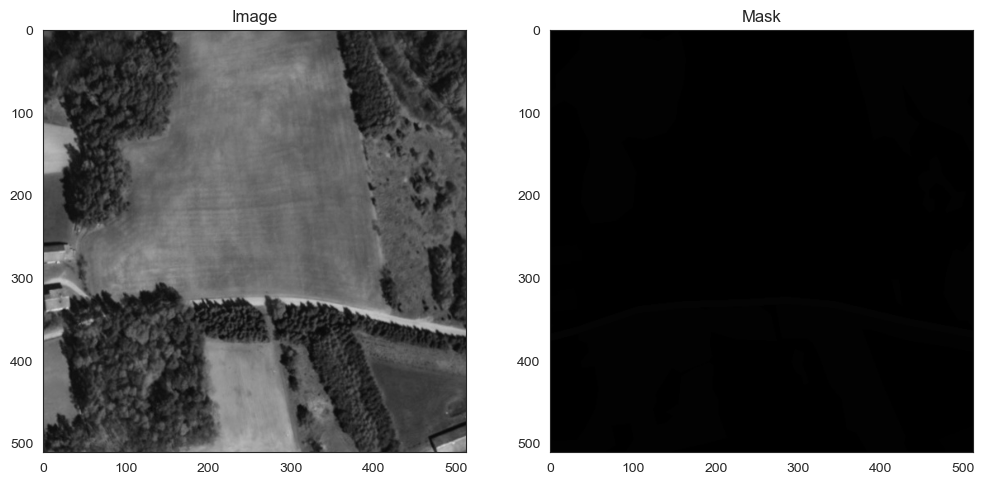

In [27]:

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
os.makedirs('C:/Users/Deepali Thakur/Landcover/images/')
os.makedirs('C:/Users/Deepali Thakur/Landcover/masks/')
useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Save Me")
        cv2.imwrite('C:/Users/Deepali Thakur/Landcover/images/'+img_name, temp_image)
        cv2.imwrite('C:/Users/Deepali Thakur/Landcover/masks/'+mask_name, temp_mask)
        
    else:
        print("I am useless")   
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571

In [ ]:

###############################################################
#Now split the data into training, validation and testing. 
import splitfolders  # or import split_folders
input_folder = 'C:/Users/Deepali Thakur/Landcover/useful/'
output_folder = 'C:/Users/Deepali Thakur/Landcover/data/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) 
# default values ########################################

In [ ]:
import os
import csv
import glob

folder_path = "C:/Users/Deepali Thakur/Landcover/data/Val_masks/val/"  # Replace with the actual folder path

# Get all PNG files in the folder
#png_files = [file for file in os.listdir(folder_path) if file.endswith(".png")]
png_files = (glob.glob('C:/Users/Deepali Thakur/Landcover/data/Val_masks/val/*.png'))

# Write filenames to a CSV file
csv_file_path = "C:/Users/Deepali Thakur/Landcover/data3.csv"  # Replace with the desired output file path

try:
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["File Name"])  # Write the header
        for png_file in png_files:
            writer.writerow([png_file])
    print("Filenames written to CSV file successfully.")
except IOError:
    print("An error occurred while writing to the CSV file.")

In [ ]:
import torchvision
#create a dataloader iterable object
dataloader_it = iter(trainDL)
#sample from the iterable object
image, label = next(dataloader_it)

plt.figure(figsize = (20,10))
img_out = torchvision.utils.make_grid(((image+1)/2)[0:2], nrow=1)
lbl_out = torchvision.utils.make_grid(label[0:2],nrow= 1).float()

out = torch.cat((img_out, lbl_out), dim = 1)

plt.imshow(out.numpy().transpose((1, 2, 0)))
#image.shape
#label.shape

In [ ]:
from torch.utils.data import DataLoader, Subset, random_split
validation_ratio = 0.2
num_samples =len(train)
num_validation_samples = int(validation_ratio * num_samples)

# Calculate the number of samples for the training set
num_train_samples = num_samples - num_validation_samples

# Randomly split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(train, [num_train_samples, num_validation_samples])

# Create DataLoader objects for training and validation
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
from segmentation_models_pytorch.utils.callbacks import CallbackRunner

# Define a callback function
def my_callback_fn(epoch, logs):
    # Custom callback logic here
    print(f"Epoch: {epoch}, Loss: {logs['loss']}")

# Create a CallbackRunner object
callback_runner = CallbackRunner()

# Add the callback function to the CallbackRunner
callback_runner.add_callback(my_callback_fn)

# Define training epoch
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
    callback=callback_runner,  # Pass the callback_runner object to the TrainEpoch
)

# Training loop
for i in range(0, num_epochs):
    train_logs = train_epoch.run(trainDL)
    # Rest of the training loop code


In [ ]:
class IoU(torch.nn.Module):
    def __init__(self):
        super(IoU, self).__init__()
        self.name = "IoU"

    def forward(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union
        return iou

# Inside a method or class
metrics = [IoU()]  # List of metrics
metrics_meters = {metric.name: AverageValueMeter() for metric in metrics}


In [ ]:
from torch.utils.data import random_split

# Assuming you have a dataset object called 'dataset' containing your training data

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(train))  # 80% of the data for training
val_size = len(train) - train_size  # Remaining data for validation

# Use random_split to split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train, [train_size, val_size])

# Now you have 'train_dataset' and 'val_dataset' as separate datasets

# Assuming you have a data loader for your training and validation sets called 'train_loader' and 'val_loader' respectively
